In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyodbc

def fecha_str(fecha):  # La funcion sirve como azucar sintactico
    """Entrega la fecha en formato string para consultas SQL
    :param fecha: Fecha para transformar a string
    :return: String con al fecha en formato YYYYMMDD
    """
    return fecha.strftime("'%Y%m%d'")

def parsear_curva(curva, fecha):
    """
    Parsea la curva para la fecha indicada y entrega un arreglo con los valores sin header
    :param curva: String con los valores de la curva en el formato 'plazo#valor|plazo1#valor1|..'
    :param fecha: datetime.date con la fecha para la curva
    :return: array de dos columnas con los valores (SIN HEADER)
    """
    res = []
    filas = curva.split('|')
    header = filas[0].split("#")
    if header[0] == 'Plazo':
        for fila in filas[1:]:
            valores_fila = fila.split('#')
            valores_fila[0].replace(",", ".")
            valores_fila[1] = valores_fila[1].replace(",", ".")
            res.append(valores_fila)
    else:
        for fila in filas[1:]:
            valores_fila = fila.split('#')
            if int(valores_fila[0]) >= 30:
                valores_fila[0] = (add_months(fecha, int(int(valores_fila[0]) / 30)) - fecha).days
            valores_fila[1] = valores_fila[1].replace(",", ".")
            res.append(valores_fila)
    return res

## Datos para extraer

In [20]:
import datetime


fecha = datetime.date(2019,4,3)
hora = "1700"
monedas = ["USD","CLP","CLF"]



## Correr el resto

In [21]:
monedas_str = str(monedas)[1:-1]
fecha_str = fecha_str(fecha)

In [22]:
cn = pyodbc.connect( 'DRIVER={SQL Server};SERVER=192.168.30.114;DATABASE=dbDerivados;UID=vcarmi;PWD=%rJp^@7v:B' )

sql = ("SELECT Curva, FechaMax, C.Hora, C.Moneda "
    "FROM TdCurvasDerivados A, TdParidadMonedasCurvasDescuento B,"
    "(SELECT MAX(Fecha) AS FechaMax, Hora, Moneda "
    "FROM TdCurvasDerivados A, TdParidadMonedasCurvasDescuento B "
    "WHERE A.Tipo = B.Tipo AND Fecha <= " + fecha_str + " AND Hora = '"+ hora + "' AND MONEDA IN (" + monedas_str + ")"
       "GROUP BY Hora, Moneda) C "
    "WHERE A.Tipo = B.Tipo AND A.Fecha = C.FechaMax AND A.Hora = C.Hora AND B.Moneda = C.Moneda")

info = pd.io.sql.read_sql(sql, cn)

In [23]:
info

,Curva,FechaMax,Hora,Moneda
0,"Plazo#Valor|1#0,999939950883994|7#0,9995663620...",2019-03-04,1700,USD
1,"Plazo#Valor|1#0,999964665286756|2#0,9999274642...",2019-03-04,1700,CLF
2,"Plazo#Valor|1#0,999929110110357|7#0,9994905074...",2019-03-04,1700,CLP


In [5]:

monedas = dict()
for i in range(len(info)):
    moneda = info.Moneda.iloc[i]
    curva = info.Curva.iloc[i]
    monedas[moneda] = parsear_curva(curva, fecha)
    for fil in monedas[moneda]:
        fil[0] = float(fil[0])
        fil[1] = float(fil[1])

        


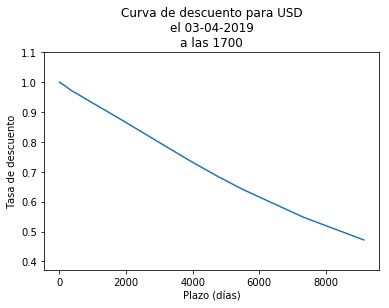

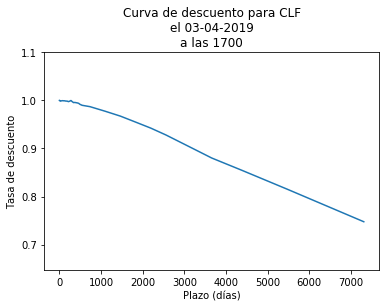

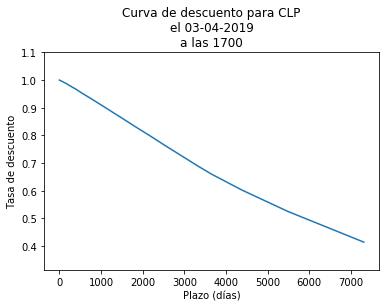

In [6]:
for i in monedas:
    plt.plot(np.transpose(monedas[i])[0], np.transpose(monedas[i])[1])
    plt.ylabel('Tasa de descuento')
    plt.xlabel('Plazo (días)')
    plt.title("Curva de descuento para " + i + "\nel " + fecha.strftime('%d-%m-%Y') + "\na las " + hora)
    plt.ylim(bottom=min(np.transpose(monedas[i])[1]-0.1))
    plt.ylim(top=max(np.transpose(monedas[i])[1]+0.1))
    plt.show()

In [18]:
dataframes = dict()
for i in monedas:
    dataframes[i] = pd.DataFrame(monedas[i], columns=["Plazo","Descuento"])
    
    
with pd.ExcelWriter(str(fecha) + 'curvas.xlsx') as writer:
    for i in dataframes:
        dataframes[i].to_excel(writer, sheet_name=str(i))